In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import os
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label


In [2]:
os.chdir('/Users/sumi/Documents/AA-Study/MOOC/SelfDrive/CarND-Vehicle-Detection')
car_path = 'Data/vehicles/'
non_car_path = 'Data/non-vehicles/'

cars = []
for path in os.listdir(car_path)[1:]:
    p = 'Data/vehicles/'+ path+'/*.png'
    cars.append(glob.glob(p))

notcars = []
for path in os.listdir(non_car_path)[1:]:
    p = 'Data/non-vehicles/'+ path+'/*.png'
    notcars.append(glob.glob(p))


cars = [item for sublist in cars for item in sublist]
notcars = [item for sublist in notcars for item in sublist]

# print(img_path[2][1])    
# print(img_path[-1][1])    

In [3]:
# Check the class balance, car and non-car is almost 1:1, so this dataset is good for training
len(cars)/len(notcars)

0.9803746654772525

In [4]:
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to compute binned color features  
def bin_spatial(img, size=32):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, (size,size)).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def convert_color(img, color_space='YCrCb'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 
    return feature_image    
    
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9,
                     spatial_size = 32 ,hist_bins = 24, hist_range = (0,256) ,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'      
        feature_image = convert_color(image, color_space='YCrCb')
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #spatial_features=[]
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        #hist_features=[]
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    # Return list of feature vectors
    return features


In [39]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial = 32
histbin = 32


t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        spatial_size =spatial ,hist_bins = histbin, hist_range = (0, 256),
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        spatial_size =spatial,hist_bins = histbin, hist_range = (0, 256),
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

In [ ]:
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [41]:
print(X_scaler.mean_)

[ 0.34088949  0.49636009  0.48861218 ...,  0.01520694  0.01320196
  0.01577675]


In [43]:
import pickle
with open('car_features.pickle', 'wb') as f:
     pickle.dump([scaled_X,y,X_scaler], f)
        

In [5]:
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

1.2 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
0.14 Seconds to train SVC...
Test Accuracy of SVC =  0.975
My SVC predicts:  [ 0.  1.  1.  0.  0.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  0.  0.  1.  0.  0.  0.  0.]
0.0022 Seconds to predict 10 labels with SVC


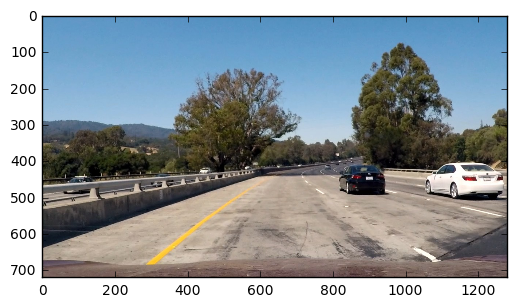

In [6]:
img = mpimg.imread('test_images/test1.jpg')
#img = cv2.resize(img,(32,32))
plt.imshow(img)

Here is my approach to exclude false positives:

Threshold prediction probability: In order to make our classifier more reliable I put a threshold on the confidence score. Only vehicles that got detected with more than 99% probability are taken into consideration.

Heatmap technique for several consecutive frames: I take advantage of the fact that wa are working with an image stream. Instead of drawing the detection windows frame by frame, I take in intervals of 30 frames. This leads to a better result in the heatmap technique and creates a much smoother annotation.

Use cv2.groupRectangles to group detection windows with similar coordinates. This method proves very powerful to sort out false positives because we can put a threshold on the minimum number of rectangles, that need to be detected to form a group. I set the threshold to 10. This means that we need at least 10 windows with similar coordinates in a certain area to get a valid detection. The relative difference between sides of each rectangles to merge them into a group is called Epsilon and I set it to 0.1. Both epsilon and minimum group threshold were tuned by experiment.

I personally found it useful going through all those steps and apply manual feature extraction.
It made me more aware of what can go wrong in object detection. Yo could argue that NN's would be more effective for this task. But they are also black boxes. Doing things the manual way is a bit cumbersome but it is very good practice.

In [6]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space='YCrCb') #RGB2YCrCb
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (spatial,spatial))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.concatenate((spatial_features, hist_features,hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img,bboxes

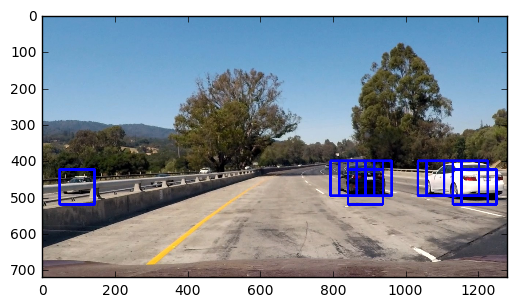

In [8]:
ystart = 400
ystop = 656
scale = 1.5
   
out_img,box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial, histbin)

plt.imshow(out_img)

In [7]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


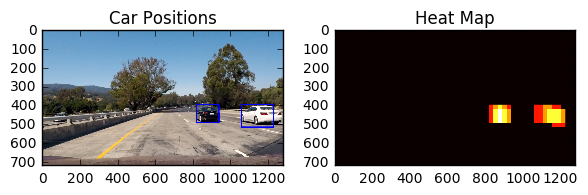

In [10]:
# Read in image similar to one shown above 
heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [29]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial = 32
histbin = 32
ystart = 400
ystop = 656
scale = 1.5


def process_image(img):
    out_img,box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial, histbin)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
#     fig = plt.figure()
#     plt.subplot(121)
#     plt.imshow(draw_img)
#     plt.title('Car Positions')
#     plt.subplot(122)
#     plt.imshow(heatmap, cmap='hot')
#     plt.title('Heat Map')
#     fig.tight_layout()
    return draw_img

    

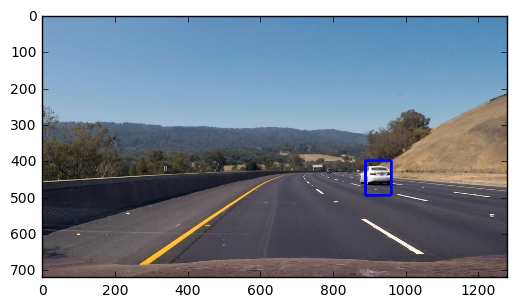

In [12]:
test_imgs = glob.glob('test_images/*.jpg')
for img in test_imgs[2:3]:
    img = mpimg.imread(img)
    #plt.imshow(img)
    result = process_image(img)
    plt.imshow(result)

In [37]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# left_lane = Line(7)
# right_lane = Line(7)
project_video_output = "project_video_output0.mp4"
clip1 = VideoFileClip("test_video.mp4")#.subclip(25,27) # select the subclip between t=25s and t=30s
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output0.mp4
[MoviePy] Writing video project_video_output0.mp4


 97%|█████████▋| 38/39 [00:14<00:00,  2.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output0.mp4 

CPU times: user 27.1 s, sys: 1.25 s, total: 28.4 s
Wall time: 16.6 s


In [44]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

In [35]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

class VehicleTracker:
#     def __init__(self,frame_size):
#         self.heatmap = np.zeros(frame_size)
#         self.frames = []
#         self.heatmaps = []
    def __init__(self,frame_size = (720,1280)):
        self.heatmap = np.zeros(frame_size)
        self.heatmaps = []
    def process_frame(self, frame):
        return process_(frame)
    
    def process_frame(self,frame):
        # do your processing...
        out_img,box_list = find_cars(frame, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial, histbin)

        
        heat = add_heat(self.heatmap,box_list)

        # example using heatmap
        #new_frame_factor = 0.3
        #self.heatmap = new_frame_factor * heat + (1-new_frame_factor) * self.heatmap
        # do threshold and some kind of detection (blob or cv.contours)
        # Add heat to each box in box list
        # self.heatmap = add_heat(self.heatmap,box_list)
        # example using averaged frame
        
        nb_frames_avg = 5
#         self.frames.append(frame)
#         avg_frame = np.mean(np.array(self.frames)[-nb_frames_avg], axis=-1)
        self.heatmaps.append(heat) 
        avg_heatmap = np.mean(np.array(self.heatmaps)[-nb_frames_avg], axis=-1)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,1)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(avg_frame)
        draw_img = draw_labeled_bboxes(np.copy(frame), labels)
                
        # do more stuff
        return draw_img

In [36]:
vehicleTracker = VehicleTracker()
project_video_output = "project_video_output1.mp4"
clip1 = VideoFileClip("test_video.mp4")#.subclip(25,27) # select the subclip between t=25s and t=30s
video_clip = clip1.fl_image(vehicleTracker.process_frame)
%time white_clip.write_videofile(project_video_output, audio=False)

IndexError: index -5 is out of bounds for axis 0 with size 1